# Material de aula - Aprendizado de Máquina


## Algoritmos Genéticos - Laboratório 06

In [1]:
#CÉLULA AG-LIB-01
import numpy as np
import math
import matplotlib.pyplot as plt
from enum import Enum
from operator import xor
%matplotlib inline

class crossoverType(Enum) : 
    OnePoint   = 1
    MultiPoint = 2
    Uniform    = 3 #usa mascara


class selectionType(Enum) : 
    roullete   = 1
    tournament = 2
    stochastic = 3

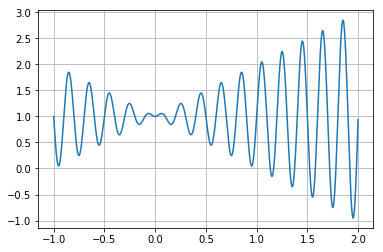

In [2]:
#CÉLULA AG-LIB-02
# Plotando o gráfico da função de Fitness
X = np.arange(-1, 2, 0.001)
Y = (X * np.sin(10*np.pi*X) + 1)

plt.figure()
plt.plot(X, Y)
plt.grid()
plt.show()

In [3]:
#CÉLULA AG-LIB-03
# Função para cálculo de escalamento e normalização de individuos
def scale(x1) :
    #esta função faz o escalamento de individuos dentro do intervalo [-1, 2]
    # 22 bits para codificar precisao de 6 digitos
    # 000000 ... 0 = -1
    # 111111 ... 1 =  2

    # ou seja, x1 em [0, 4194303] -> 2^nbits - 1
    
    #Teorema de Tales
    # ( x2 - x2_min ) / ( x2_max - x2_min ) = ( x1 - x1_min ) / (x1_max - % x1_min);
    
    #Isolando x2, a variavel de interesse
    # x2 = ( ( x1 - x1_min ) / (x1_max - x1_min) )* ( x2_max - x2_min ) + x2_min;

    #Usando valores: x2_max = 2, x2_min = -1, x1_min =0, x1_max = 4194303
    value = (3 * x1 / 4194303) - 1
    return round(value, 6)

In [4]:
#CÉLULA AG-LIB-04
# Função para cálculo de fitness (aptidão de cada individuo)
def fitness(individual) :
    x1 = float(scale(individual))
    result = (x1 * np.sin(10*np.pi*x1) + 1)
    return round(result, 6)

In [5]:
#CÉLULA AG-LIB-05
def plot_population(P, generation):
    
    xmin=-1
    xmax=2
    ymin = -1
    ymax = 3
    
    xAxis = []
    yAxis = []
    for individual in P : #pega os individuos na população
        xAxis.append(scale(individual))
        yAxis.append(fitness(individual))
    
    plt.figure()
    plt.plot(xAxis, yAxis, 'bo')
    plt.axis([xmin, xmax, ymin, ymax])
    
    plt.xlabel('x')
    plt.ylabel('y')
    sTitle = ('Populacao na geração {}'.format(generation))
    plt.title(sTitle)
    plt.grid()

In [6]:
#CÉLULA AG-LIB-06
def checkStopCondition(P, stop_condition, epson):
    y = [fitness(individual) for individual in P]
    
    if( abs(max(y) - min(y)) < epson) :
        print('Todos os individuos convergiram')
        return True
    
    outliers = [1 for fitness_individual in y if abs(max(y) - fitness_individual) < epson]
    #print(len(outliers))
    
    if( (len(outliers) / len(P)) >= stop_condition) :
        print('Pelo menos {}% de todos os individuos convergiram'.format(stop_condition * 100))
        return True
    
    return False    

In [7]:
#CÉLULA AG-LIB-07
# Função que efetua o sorteio no estilo roleta entre 0 e aptidacao maxima acumulada
# P        -> população de individuos
# vFitness -> vetor com valores de aptidão alinhado com P

def roulette(P, vFitness) :
    maxFitness = sum(vFitness)
    rouletteVal = np.random.rand() * maxFitness
    
    iAcumFitness = 0
    for fitnessVal, index in zip(vFitness, range(0, len(vFitness))):
        iAcumFitness = iAcumFitness + fitnessVal
        if(iAcumFitness >= rouletteVal) :                
            return P[index]
    
    return -1

In [8]:
#CÉLULA AG-LIB-08
# Realiza o torneio de uma população P
# Sorteia 2 inidividuos e retorna aquele com maior aptidão
# Nada impede que os torneios possam ter mais de 2 individuos

def tournament(P) :
    v = np.random.randint(0, len(P), size=(2))
    #Compara as aptidoes
    if( fitness(P[v[0]]) >= fitness(P[v[1]])) :
        #return P.item(v[0]) # desse jeito retorna só o valor
        return P[v[0]] #desse jeito retorna um ndarray
    else:
        #return P.item(v[1]) 
        return P[v[1]]

In [9]:
#CÉLULA AG-LIB-10
# P                 -> população 
# method            -> enum que indica o metodo de seleção natural
# qty_candidates    -> quantidade de 'selecionados'
#candidates_index   -> lista de candidatos selecionados
# sus_qty_pointers  -> quantidade de agulhas da roleta da amostragem universal estocastica (SUS)

def selectCandidates(P, method, qty_candidates, sus_qty_pointers) :
    candidatesList = []
    
    #Ordena a população em termos de suas aptidões
    #Esta ordenação é necessária para seleção em roleta ou SUS
    vFitness = [fitness(p) for p in P]
    p_tuple = zip(vFitness, P)    
    sorted_by_fitness = sorted(p_tuple, key=lambda tup: tup[0])

    P = []
    vFitnessNormal = []
    for (fitnessVal, p) in sorted_by_fitness :
        P.append(p)
        vFitnessNormal.append(fitnessVal)
    
    if (method == selectionType.roullete) :
        #Roleta
        #Deslocaremos a aptidão da população, pois possui valores negativos, assim é possivel calcular o valor acumulado
        #vFitnessNormal = [fitness(x) for x in P]
        vFitnessShifted = [ (2*abs(min(vFitnessNormal)) + x) for x in vFitnessNormal ]                
        
        for i in range(0, qty_candidates) :
            winner = roulette(P, vFitnessShifted)
            if(winner != -1) :
                candidatesList.append(winner)
        
    elif (method == selectionType.tournament) :
        #Torneio
        for i in range(0, qty_candidates) :
            winner = tournament(P)
            candidatesList.append(winner)
    else : 
        #Amostragem Universal Estocastica - é uma roleta com multiplos ponteiros (sus_qty_pointers)
        #Deslocaremos a aptidão da população, pois possui valores negativos, assim é possivel calcular o valor acumulado
        #vFitnessNormal = [fitness(x) for x in P]
        vFitnessShifted = [ (2*abs(min(vFitnessNormal)) + x) for x in vFitnessNormal ]                

        vWinners = []
        vWinners = stochasticUniversalSampling(P, vFitnessShifted, sus_qty_pointers)
        for winner in vWinners : 
            candidatesList.append(winner)
        
    return candidatesList

In [10]:
#CÉLULA AG-LIB-11
# Faz o cruzamento
# candidatesList    -> lista de individuos mais aptos
# reproduction_rate -> probabilidade de ocorrer um crossover
# populationSize    -> tamanho esperado da populacao apos o crossover
# mode              -> indica o tipo de cruzamento (um ponto, multi-ponto, com mascara)
# mask              -> mascara para crossover

def crossover(candidatesList, reproduction_rate, populationSize, mode, crossoverMask) :
    childrenList = []
    
    for i in range(0, int(populationSize / 2)) :
        #escolhe dois individuos ao acaso
        v = np.random.randint(0, len(candidatesList), size=(2))
        
        p1 = candidatesList[v[0]]
        p2 = candidatesList[v[1]]


        #decide se vai ocorrer reproducao, caso contrario, os filhos serao apenas copias dos pais
        if (np.random.rand() >= reproduction_rate ) :
            if (mode == crossoverType.OnePoint) :                
                #Crossover em um ponto, na metade do cromossomo
                
                p1Bin = "{0:022b}".format(p1) #formata numero em 22 bits
                p2Bin = "{0:022b}".format(p2) #formata numero em 22 bits

                #Faz o slice
                geneP1L = p1Bin[0:11]
                geneP1R = p1Bin[11:22]
                
                geneP2L = p2Bin[0:11]
                geneP2R = p2Bin[11:22]
                
                #Realiza o cruzmento
                #concatena os genes e converte para numero inteiro
                c1 = int(geneP1L+geneP2R, 2) 
                c2 = int(geneP2L+geneP1R, 2)
                
                #Adiciona ao array de filhos
                childrenList.append(c1)
                childrenList.append(c2)
            elif(mode == crossoverType.MultiPoint) :
                #Crossover multi-ponto, realizado na posicao 8 e 16
                p1Bin = "{0:022b}".format(p1) #formata numero em 22 bits
                p2Bin = "{0:022b}".format(p2) #formata numero em 22 bits

                #Slicing
                geneP1L = p1Bin[0:8]
                geneP1M = p1Bin[8:16]
                geneP1R = p1Bin[16:22]
                
                geneP2L = p2Bin[0:8]
                geneP2M = p2Bin[8:16]
                geneP2R = p2Bin[16:22]

                #Realiza o cruzamento, trocando somente a parte do meio
                #concatena os genes e converte para numero inteiro
                c1 = int(geneP1L + geneP2M + geneP1R, 2) 
                c2 = int(geneP2L + geneP1M + geneP2R, 2)
                
                #Adiciona ao array de filhos
                childrenList.append(c1)
                childrenList.append(c2)                            
        else:
            # Não ocorreu reprodução, os filhos são copias dos pais
            childrenList.append(p1)
            childrenList.append(p2)
    
    return childrenList

In [11]:
#CÉLULA AG-LIB-12
# realiza a mutação de individuo
# candidatesList    -> lista de individuos gerados pelo crossover
# mutation_rate     -> probabilidade de ocorrer uma mutação

def mutation(candidatesList, mutation_rate) :
    
    mutatedList = []
    
    for p in candidatesList :
        if (np.random.rand() <= mutation_rate ) :
            #realiza mutação
            pBin = list("{0:022b}".format(p)) #formata numero em 22 bits

            #sorteia um bit para sofrer mutação
            mutationIndex = np.random.randint(0,len(pBin))
            
            #Aplica mutação
            if (pBin[mutationIndex] == '0') :
                pBin[mutationIndex] = '1'
            else:
                pBin[mutationIndex] = '0'

            #Transforma pBin (lista) em string e a seguir, em inteiro
            pBinStr = ''.join(pBin)
            mutatedList.append(int(pBinStr, 2))
        
        else:
            mutatedList.append(p)
    
    return mutatedList

# 1 - Criando o AG

Utilizando Jupyter e NumPy: para a função de variável contínua apresentada, complete a implementação do algoritmo.

In [12]:
# CÉLULA AG-MAIN-01
#Parâmetros
size_pop = 100
max_generations = 100
stop_condition = 0.95
reproduction_rate = 0.7
mutation_rate=0.01

min_individual = 0
max_individual = 2**22-1
sus_qty_pointers = 4 #quantidade de ponteiros da roleta do tipo SUS
crossoverMask = '0b0000111100001111000111' #mascara para crossover

In [ ]:
# CÉLULA AG-MAIN-02
#Inicializando população
P=[]

#IMPLEMENTAR
#Crie inidivuos aleatoriamente dentro do dominio da população

P = #<codigo aqui>
P = P.tolist()

In [ ]:
# CÉLULA AG-MAIN-03
plot_population(P, 1)
print(P)

In [ ]:
# CÉLULA AG-MAIN-04
#Loop principal
generation_index = 0
while( generation_index != max_generations) : 
    generation_index = generation_index + 1
        
    #print(P)
    #print('================================')
    
    if(generation_index % 2 == 0) :
        plot_population(P, generation_index)
    
    stop = checkStopCondition(P, stop_condition, 0.000001)
    if(stop == True) :
        print('Convergencia atingida')
        break

    #IMPLEMENTAÇÃO DO ALGORITMO
    
    #SELECIONE OS MAIS APTOS, 50% DA POPULAÇÃO
    
    #REALIZE O CRUZAMENTO
    
    #APLIQUE A MUTAÇÃO
    
    #ATUALIZE A LISTA DA POPULAÇÃO PARA A PROXIMA GERAÇÃO
        

    #==========================================================================================
        
print(len(childrenList))
#print(P)
print(childrenList)
print(generation_index)

In [ ]:
# CÉLULA AG-MAIN-05
#Verificando os resultados

bestFitness    = fitness(childrenList[0])
bestIndividual = childrenList[0]
for p in childrenList :
    if(fitness(p) >= bestFitness) :
        bestFitness = fitness(p)
        bestIndividual = p

print('A convergencia foi atingida na geração: {}'.format(generation_index))
print('O cromossomo vencedor foi: {}->({})b, ou seja, x={} com aptidão {}'.format(bestIndividual, "{0:022b}".format(p), scale(bestIndividual), bestFitness))
print('A solução do problema é x={}'.format(scale(bestIndividual)))

plot_population(P, generation_index)

## Validação

### Execute algumas vezes e verifique o resultado.